In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:


from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
import torchvision.transforms as transforms

def get_data_loader(batch_size):
    """ Loads images of faces, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    Also visualize data from loader
    
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
    """

    
   #We used PyTorch's torchvision.datasets.ImageFolder to load the data from Google drive and transform to tensors fro training

    # transform = transforms.Compose([transforms.Resize((128,128)), transforms.Grayscale(),
    #                             transforms.ToTensor()])
    transform = transforms.Compose([transforms.Resize((128,128)), 
                                transforms.ToTensor()])

    data = torchvision.datasets.ImageFolder(root="/content/gdrive/My Drive/APS 360/dataset_final",transform=transform)
    
    # Split into train and validation
    split = int(0.8 * len(data))
    
    train_size = int(0.8 * len(data))
    test_size = len(data) - train_size

    #train and test 
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size],generator=torch.Generator().manual_seed(1000))

    #train and validation split 
    train_size_split=int(0.8 *len(train_dataset))
    validation_size_split = len(train_dataset) - train_size_split

    train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size_split, validation_size_split],generator=torch.Generator().manual_seed(1000))
    print("The length of training data set is " ,len(train_dataset))
    print("The length of the validation data set is ", len(validation_dataset))
    print("The length of the test data set is " ,len(test_dataset))

    #data loader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size , shuffle=True)
    test_loader=torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=True)
    
    # #Code for visualization prior to training
    # fig=plt.figure(figsize=(20, 10))
    # k = 0
    # for images, labels in train_loader:
    #     image = images[0]
    # # place the colour channel at the end, instead of at the beginning
    #     img = np.transpose(image, [1,2,0])
    #     plt.subplot(3, 5, k+1)
    #     plt.axis('off')
    #     plt.imshow(img)
    #     plt.title((labels[0]))

    #     k += 1
    #     if k > 10:
    #         break



    return train_loader, val_loader, test_loader,train_dataset,validation_dataset

In [ ]:
#Testing our data loader function
get_data_loader(32)

The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200


(<torch.utils.data.dataloader.DataLoader at 0x7f0905de5710>,
 <torch.utils.data.dataset.Subset at 0x7f0905de55f8>)

In [ ]:

import torch.nn.functional as F

#The CNN Network
class MaskNet(nn.Module):
    def __init__(self):
        super(MaskNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.conv2 = nn.Conv2d(20,40 , kernel_size=3,stride=1,padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)


        self.fc1 = nn.Linear(64 * 64 * 40, 32)
        self.fc2 = nn.Linear(32, 2)
        

    def forward(self, x):
        x = (F.relu(self.conv1(x.float())))
        x=self.pool(x)
        x = F.relu(self.conv2(x.float()))
       
        x = x.view(-1, 40 * 64* 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return  x


In [ ]:
#Experimenting with number of hidden units
import torch.nn.functional as F

#The CNN Network
class MaskNet2(nn.Module):
    def __init__(self):
        super(MaskNet2, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(1, 100, kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.conv2 = nn.Conv2d(100,200 , kernel_size=3,stride=1,padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)


        self.fc1 = nn.Linear(64 * 64 * 200, 90)
        self.fc2 = nn.Linear(90, 2)
        

    def forward(self, x):
        x = (F.relu(self.conv1(x.float())))
        x=self.pool(x)
        x = F.relu(self.conv2(x.float()))
       
        x = x.view(-1, 200 * 64* 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return  x


In [ ]:
import time
import torch.optim as optim




def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30,large_dataset="True",train_loader_small=None,val_loader=None,test_loader=None,train_data=None,validation_data=None):
 ########################################################################
    
   
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    if(large_dataset=="True"):
       train_loader, val_loader, test_loader,train_data,validation_data = get_data_loader(batch_size)
    else:
        train_loader, val_loader, test_loader=train_loader_small,val_loader,test_loader

    
    start_time = time.time()
     
     # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    losses,iters  = [],[]
    # Set up some numpy arrays to store the training/test loss/accuracy
    train_acc = []
    val_acc = []
    


  

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print(epoch)
        for i, data in enumerate(train_loader, 0):
            #############################################
            inputs, labels = data

            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
               inputs = inputs.cuda()
               labels = labels.cuda()
            #############################################
            # Get the inputs

            out = net(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)

            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1
            train_acc.append(get_accuracy(net,train_data=train_data,validation_data=validation_data, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(net,train_data=train_data,validation_data=validation_data, train=False))  # compute validation accuracy
          

        
         # Save the current model (checkpoint) to a file
        if(epoch%10==0):
           model_path = get_model_name("Transfer_Learning", batch_size, learning_rate, epoch)
           torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
            
# plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
 
   

In [ ]:



#From tutorial
def get_accuracy(model, train_data,validation_data,train=False):

    if train:
        data = train_data
    else:
        data = validation_data
    
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=128):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs) # We don't need to run F.softmax
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


 

In [ ]:
# Overfitting to a small data set
#Manually creating a small data set:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.Grayscale(),
                                transforms.ToTensor()])

import random
data = torchvision.datasets.ImageFolder(root="/content/gdrive/My Drive/APS 360/dataset_final",transform=transform)

mask_count=0
nomask_count=0
indices=[]
while (mask_count<100 or nomask_count<100):
         value = random.randint(0, 4000)
         if value not in indices: 
              if (data[value][1]==0 and mask_count<100):
                  mask_count=mask_count+1
                  indices.append(value)
                  print(mask_count)
              elif(data[value][1]==1 and nomask_count<100):
                   nomask_count=nomask_count+1
                   indices.append(value)
                   print(nomask_count)


        



data_small = torch.utils.data.Subset(data, indices)  #Approximately 300 images



     
    


1
1
2
3
2
4
3
4
5
5
6
7
8
9
10
6
7
11
8
9
12
10
11
13
12
14
15
16
13
17
18
14
19
15
20
21
22
16
17
23
18
24
25
26
19
20
27
28
29
30
21
31
22
32
33
34
35
36
37
38
23
24
25
26
39
40
41
42
27
43
44
45
46
47
28
29
48
49
50
51
52
53
54
30
55
56
57
31
58
59
60
32
61
33
62
63
64
65
66
67
68
69
34
70
71
72
73
74
35
75
76
36
77
78
79
80
81
37
38
82
83
84
85
86
87
88
89
90
91
92
93
94
39
95
96
97
98
99
40
41
100
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [ ]:
mask_count=0
nomask_count=0
for i in range(0,199,1):
      if(data_small[i][1]==0):
        mask_count=mask_count+1
      else:
        nomask_count=nomask_count+1
print(mask_count)
print(nomask_count)
#SO WE NOW HAVE A SMALL BALANCED DATA SET WITH EQUAL MASK AND NO MASK IMAGES


100
99


The small data  set is  200
CUDA is available!  Training on GPU ...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Finished Training
Total time elapsed: 335.81 seconds


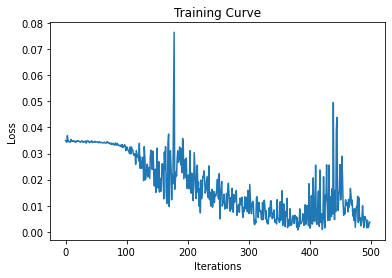

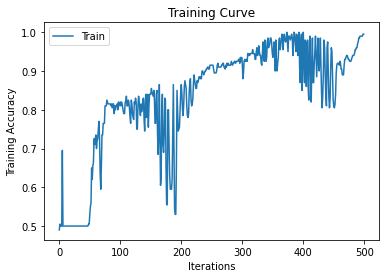

Final Training Accuracy: 0.995


In [ ]:


#data loader
train_loader_small = torch.utils.data.DataLoader(data_small, batch_size=20, shuffle=True)
print("The small data  set is ", len(data_small))
#Neural Network- training CNN

use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=20, learning_rate=0.001, num_epochs=50,
          large_dataset="False",train_loader_small=train_loader_small,train_data=data_small)



CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
Finished Training
Total time elapsed: 8995.05 seconds


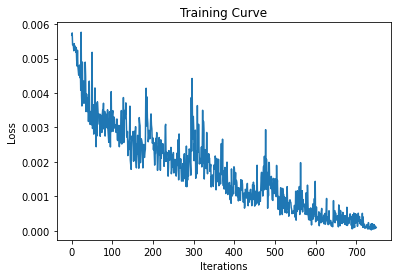

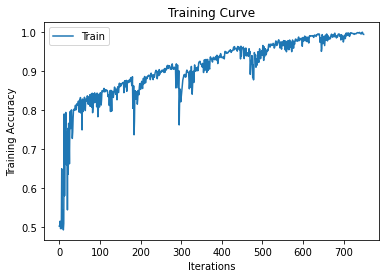

Final Training Accuracy: 0.9940104166666667


In [ ]:
use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=128, learning_rate=0.01, num_epochs=25,
          large_dataset="True")


In [ ]:
 
saved_model = MaskNet()
saved_model.load_state_dict((torch.load("/content/model_MaskNet1_bs128_lr0.01_epoch20")))
saved_model.eval()


train_loader, val_loader, test_loader,train_data,validation_data = get_data_loader(batch_size=128)


correct = 0
total = 0

for i, data in enumerate(val_loader, 0):
        imgs, labels = data
        
        # Forward pass, backward pass, and optimize
        output = saved_model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
accuracy= correct / total
print("validation final classification accuracy is", accuracy)   

The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
validation final classification accuracy is 0.8864583333333333


CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Finished Training
Total time elapsed: 6294.50 seconds


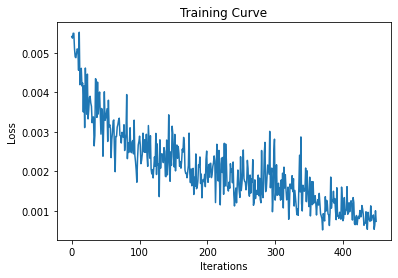

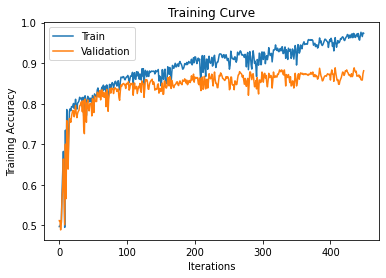

Final Training Accuracy: 0.9736979166666667
Final Validation Accuracy: 0.88125


In [ ]:
#Image size-224x224
#CNN-Masknet1
#lr=0.01
#sgd optimizer

use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=128, learning_rate=0.01, num_epochs=15,
          large_dataset="True")


CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
Finished Training
Total time elapsed: 3890.95 seconds


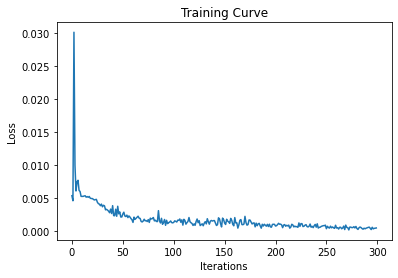

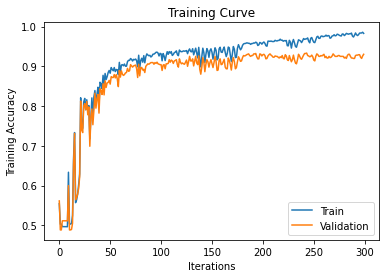

Final Training Accuracy: 0.9828125
Final Validation Accuracy: 0.9302083333333333


In [ ]:

#Image size-128x128
#CNN-Masknet1
#lr=0.001
#Adam optimizer
#batch size-128
use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=128, learning_rate=0.001, num_epochs=10,
          large_dataset="True")


CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Finished Training
Total time elapsed: 5170.38 seconds


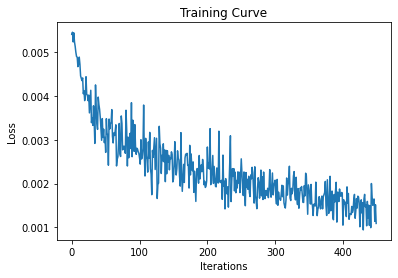

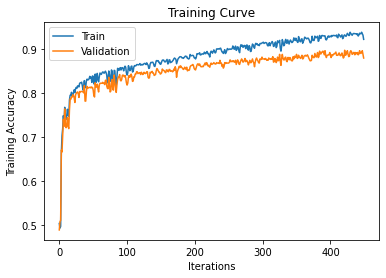

Final Training Accuracy: 0.9216145833333333
Final Validation Accuracy: 0.8791666666666667


In [ ]:

#Image size-128x128
#CNN-Masknet1
#lr=0.001
#Adam optimizer
#batch size-128
use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=128, learning_rate=0.0001, num_epochs=15,
          large_dataset="True")


CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Finished Training
Total time elapsed: 5290.00 seconds


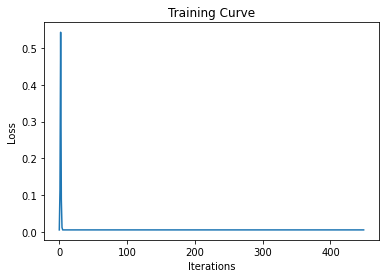

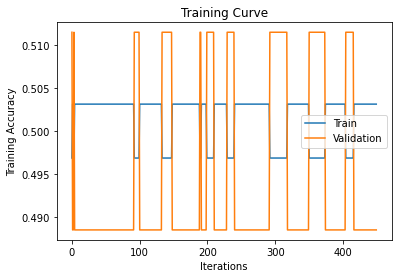

Final Training Accuracy: 0.503125
Final Validation Accuracy: 0.48854166666666665


In [ ]:

#Image size-128x128
#CNN-Masknet1
#lr=0.001
#Adam optimizer
#batch size-128
use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=128, learning_rate=0.01, num_epochs=15,
          large_dataset="True")


CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
Finished Training
Total time elapsed: 1685.35 seconds


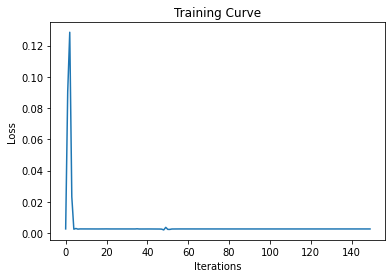

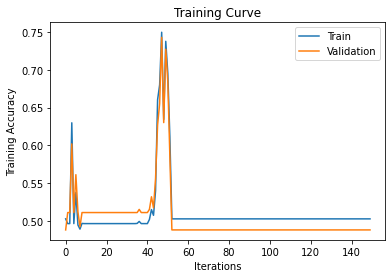

Final Training Accuracy: 0.503125
Final Validation Accuracy: 0.48854166666666665


In [ ]:

#Image size-128x128
#CNN-Masknet1
#lr=0.01
#Adam optimizer
#batch size-256

use_cuda = True

CNN = MaskNet()

if use_cuda and torch.cuda.is_available():
  CNN.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN, batch_size=256, learning_rate=0.01, num_epochs=10,
          large_dataset="True")


CUDA is available!  Training on GPU ...
The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200
0
1
2
3
4
5
6
7
8
9
Finished Training
Total time elapsed: 5727.24 seconds


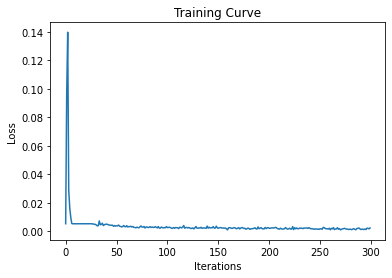

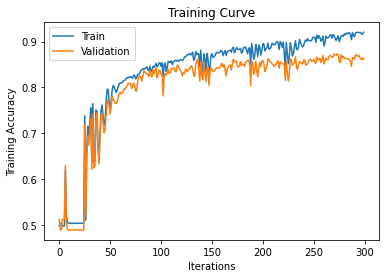

Final Training Accuracy: 0.9203125
Final Validation Accuracy: 0.8614583333333333


In [ ]:




#Image size-128x128
#CNN-Masknet2-more hidden units
#lr=0.001
#Adam optimizer
#batch size=128
use_cuda = True

CNN2 = MaskNet2()

if use_cuda and torch.cuda.is_available():
  CNN2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_net(CNN2, batch_size=128, learning_rate=0.001, num_epochs=10,
          large_dataset="True")


In [ ]:
#Using ResNet for Transfer Learning:
from torchvision import models

ResNetmodel =  models.resnet34(pretrained=True)



Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#  ResNetmodel.eval()


In [ ]:
#Removing the last linear layer-fc in the model-alterative way below
# classifier_name, old_classifier = ResNetmodel._modules.popitem()
# ResNetmodel.eval()
#We remove last linear layer because we will be using our own classifier
ResNetmodel.fc = nn.Identity()



In [ ]:
#Computing features of a sample image
train_loader, val_loader, test_loader,train_dataset,validation_dataset=get_data_loader(1)

The length of training data set is  3840
The length of the validation data set is  960
The length of the test data set is  1200


In [ ]:
i=0
for inputs, labels in (train_loader):
            #############################################
         
            print(i)
            if(i==1):
               break
            i=i+1
            #To Enable GPU Usage
            if  torch.cuda.is_available():
               inputs = inputs.cuda()
               ResNetmodel.to('cuda')
            print('Here')
            with torch.no_grad():
                  output = ResNetmodel(inputs)
            print(output.shape)
            print(labels)

#These are the features. The feature size is 512-we use a batch size=1 while loading data

0
Here
torch.Size([1, 512])
tensor([0])
1


In [ ]:
#Setting a for loop to compute the features and save it to drive
#SOLUTION:to compute features-function
import os


def compute_features(train_loader):
    for i, data in enumerate(train_loader, 0):

            #############################################
            inputs, labels = data
            # if(i==1):
            #    break
            if(labels==0):
                labels='mask'
            else:
                labels='nomask'
            #To Enable GPU Usage
            if  torch.cuda.is_available():
               inputs = inputs.cuda()
              #  labels = labels.cuda()

               ResNetmodel.to('cuda')
            
            with torch.no_grad():
                  output = ResNetmodel(inputs)
                  #This line is NEEDED OTHER WISE ERRORS IN BACK PROPAGATION!!
                  features_tensor = torch.from_numpy(output.detach().cpu().numpy())
                  #We use torch.save to save the computed features
                  torch.save(features_tensor.squeeze(0),'/content/gdrive/My Drive/APS 360/Features/Test/'+(labels)  + '/' + str(i) + '.tensor')

                  



In [ ]:
compute_features(train_loader)

In [ ]:
compute_features(val_loader)

In [ ]:
compute_features(test_loader)

In [ ]:
#Now we set up a neural net classifier on top of the ResNet-this classifier uses the features computed from ResNet and traines on top of it 
torch.manual_seed(1) # set the random seed

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(512,300)
        self.layer2 = nn.Linear(300, 32)
        self.layer3 = nn.Linear(32, 2)

    def forward(self, img):
        flattened = img.view(-1, 512)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)

        return activation3

classifier = Classifier()


In [ ]:
# #Now we load the saved features
# transform = transforms.Compose([
#                                 transforms.ToTensor()])
# data = torchvision.datasets.ImageFolder(root="/content/gdrive/My Drive/APS 360/Features/Train",transform=transform)






# # use_cuda = True


# # import torch.nn.functional as F

# # if use_cuda and torch.cuda.is_available():
# #   classifier.cuda()
# #   print('CUDA is available!  Training on GPU ...')
# # else:
# #   print('CUDA is not available.  Training on CPU ...')
  
# # #proper model
# # train_net(classifier, batch_size=128, learning_rate=0.01, num_epochs=25,
# #           large_dataset="True")
